In [1]:
library(IRdisplay)
library(Cairo)
library(data.table)
library(arrow)
library(ggplot2)
library(cowplot)
library(ggrepel)
library(ggthemes)
library(ggpubr)
library(ggtext)
library(patchwork)
library(grid)
library(gridExtra)
library(scales)
library(stringr)
library(RColorBrewer)
library(yaml)
library(plyr)
library(tidyverse)
library(png)
library(rstatix)
library(PRROC)
library(lme4)
library(biomaRt)


Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp



Attaching package: ‘ggthemes’


The following object is masked from ‘package:cowplot’:

    theme_map



Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend



Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots



Attaching package: ‘plyr’


The following object is masked from ‘package:ggpubr’:

    mutate


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()      masks plyr::arrange()
✖ dplyr::between()      masks data.table::between()
✖ readr::col_factor()   masks scales::col_factor()
✖ dplyr::combine()      masks gr

In [2]:
FONTSIZE = 12
THEME = theme_cowplot(font_size = FONTSIZE, font_family = 'Helvetica') + theme(plot.tag = element_text(face = "bold"))

## Load data

In [3]:
output_path = '/data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/plots'

In [4]:
abexp_annotation_path = file.path('/s/project/rep/processed/training_results_v16/gtex_benchmark_with_annotation_final.parquet')

In [5]:
df = open_dataset(abexp_annotation_path) %>% collect() %>% as.data.table()

In [6]:
df = df[!is.na(`enformer@Enformer`), .(`gene`, `tissue`, `zscore`, `FDR`, `enformer@Enformer`, `individual`, `is_underexpressed_outlier`)]

In [7]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,5649072,301.7,10571112,564.6,7357093,393.0
Vcells,12020378,91.8,6503684768,49619.2,7723252796,58923.8


In [8]:
dim(df)

[1] 353745      7

In [9]:
head(df)

gene,tissue,zscore,FDR,enformer@Enformer,individual,is_underexpressed_outlier
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>
ENSG00000004777,Adipose - Subcutaneous,-0.9654289,1,-0.0018049398,GTEX-1117F,FALSE
ENSG00000004777,Adipose - Visceral (Omentum),-1.2409722,1,0.0008951686,GTEX-1117F,FALSE
ENSG00000004777,Artery - Coronary,-0.1160977,1,-0.0104330899,GTEX-1117F,FALSE
ENSG00000004777,Brain - Cortex,-1.8208154,1,-0.0394712724,GTEX-1117F,FALSE
ENSG00000004777,Breast - Mammary Tissue,-0.4914536,1,-0.0099881291,GTEX-1117F,FALSE
ENSG00000004777,Heart - Atrial Appendage,-0.4914922,1,-0.0026008599,GTEX-1117F,FALSE


## Gene statistics

In [10]:
df[, N := .N, by = gene]
df[, R2 := round(summary(lm(zscore ~ `enformer@Enformer`))$r.squared, 3), by = gene]
df[, Correlation := cor(`enformer@Enformer`, zscore), by = gene]
df[, individuals := length(unique(individual)), by = gene]
df[, label := paste0(gene,': ', N,' samples \n R2: ',R2)]

Warning message in cor(`enformer@Enformer`, zscore):
“the standard deviation is zero”
Warning message in cor(`enformer@Enformer`, zscore):
“the standard deviation is zero”
Warning message in cor(`enformer@Enformer`, zscore):
“the standard deviation is zero”
Warning message in cor(`enformer@Enformer`, zscore):
“the standard deviation is zero”
Warning message in cor(`enformer@Enformer`, zscore):
“the standard deviation is zero”
Warning message in cor(`enformer@Enformer`, zscore):
“the standard deviation is zero”
Warning message in cor(`enformer@Enformer`, zscore):
“the standard deviation is zero”
Warning message in cor(`enformer@Enformer`, zscore):
“the standard deviation is zero”
Warning message in cor(`enformer@Enformer`, zscore):
“the standard deviation is zero”
Warning message in cor(`enformer@Enformer`, zscore):
“the standard deviation is zero”
Warning message in cor(`enformer@Enformer`, zscore):
“the standard deviation is zero”
Warning message in cor(`enformer@Enformer`, zscore):
“

`geom_smooth()` using formula = 'y ~ x'


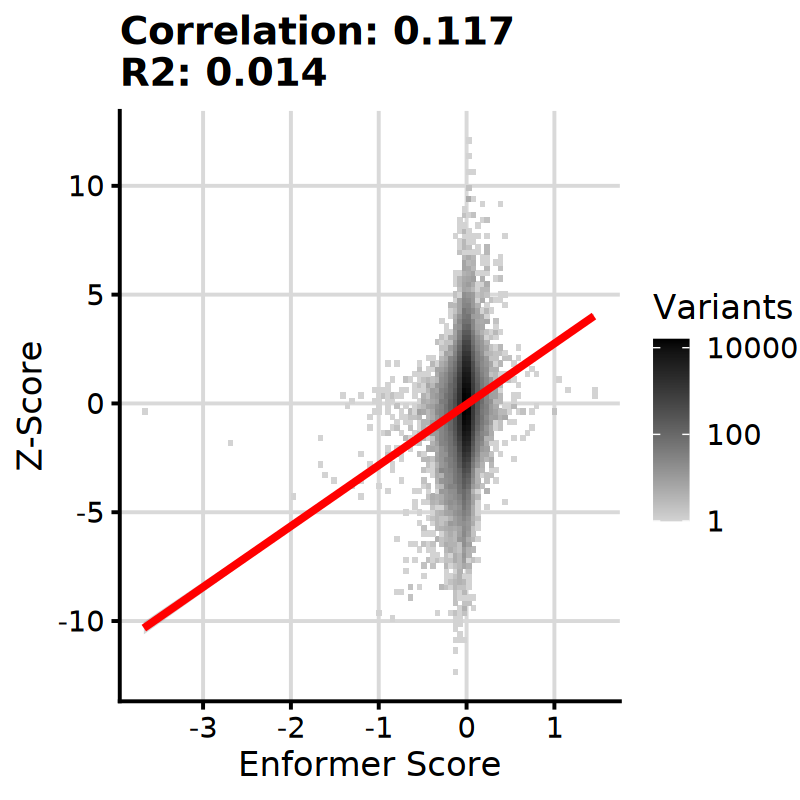

In [11]:
global_correlation = df[, round(cor(`enformer@Enformer`, zscore), 3)]
globalR2 = df[, round(summary(lm(zscore ~ `enformer@Enformer`))$r.squared, 3)]

options(repr.plot.width=4, repr.plot.height=4, repr.plot.res=200)
# Create scatter plots for the top 3 genes
p1 = ggplot(df, aes(x = `enformer@Enformer`, y = `zscore`)) +
  geom_bin2d(bins=100) +
  scale_fill_gradient(name = "Variants", trans = "log10", low="lightgrey", high="black") +
  geom_smooth(method = "lm", se = TRUE, color='red') +  # Add regression lines
  labs(x = "Enformer Score",
       y = "Z-Score", title=paste0('Correlation: ', global_correlation, '\nR2: ', globalR2)) +
  THEME + background_grid()
p1

In [12]:
gene_stats = df[,.SD[1],by=gene]
# summary(gene_stats)

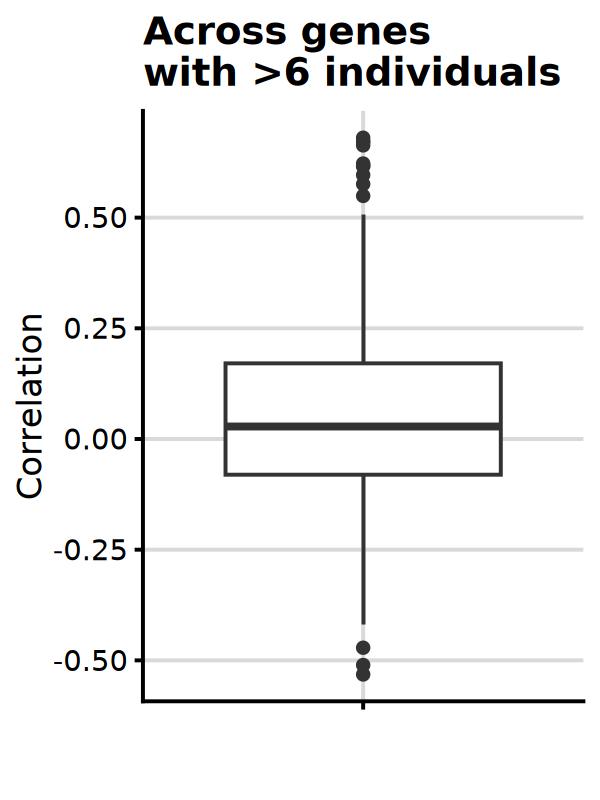

In [13]:
options(repr.plot.width=3, repr.plot.height=4, repr.plot.res=200)
p2 = ggplot(df[individuals>6,.SD[1, .(Correlation=Correlation)],by=gene], aes(x='', y=Correlation)) + geom_boxplot() + THEME + background_grid() + labs(title='Across genes\nwith >6 individuals', x='')
p2

`geom_smooth()` using formula = 'y ~ x'


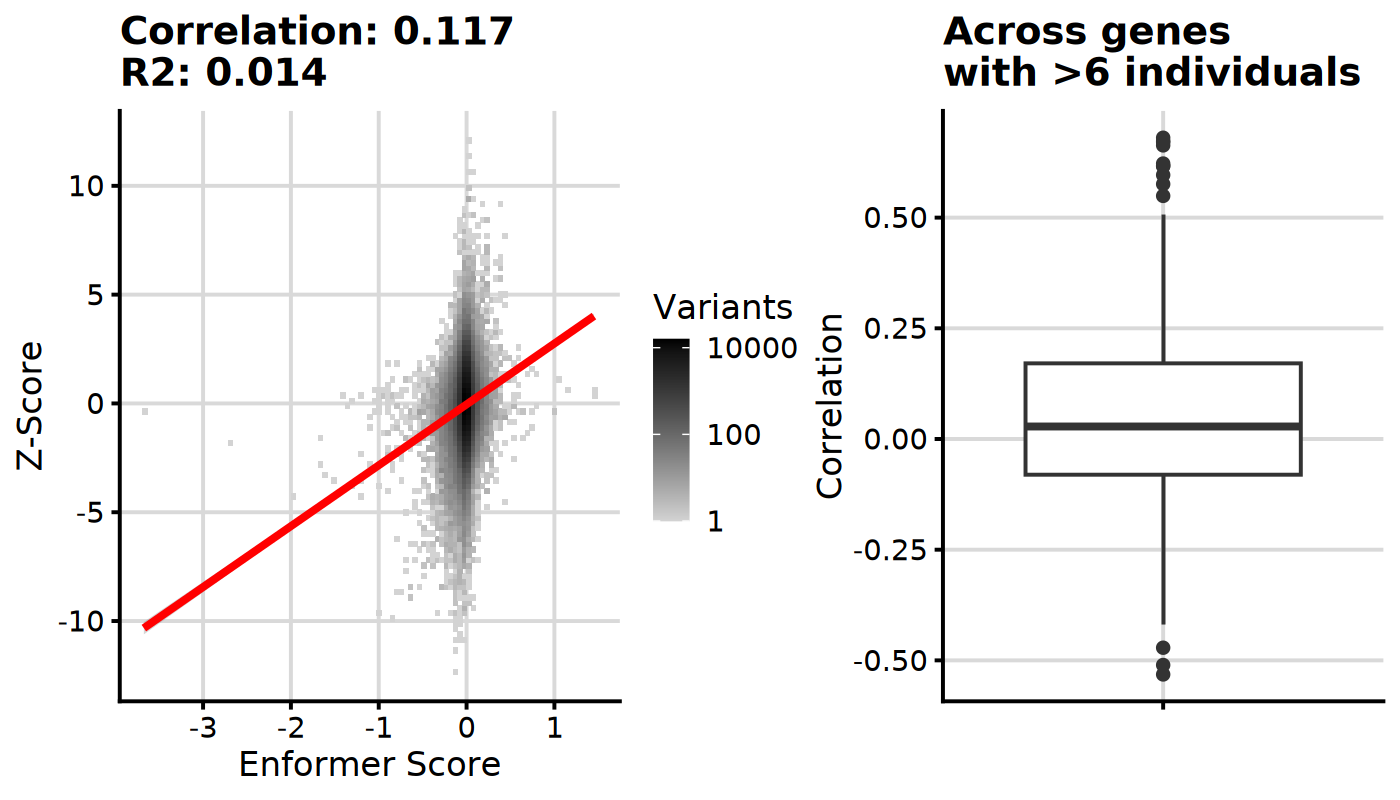

In [14]:
options(repr.plot.width=7, repr.plot.height=4, repr.plot.res=200)
p3 <- plot_grid(p1, p2, rel_widths = c(4, 3))
p3

In [15]:
width=7
height=4

path = paste(output_path, 'enformer_correlation', sep='/')
print(paste0("Saving to ", path, "..."))
ggsave(paste0(path, ".png"), p3, width = width, height = height, dpi=600, type='cairo')

[1] "Saving to /data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/plots/enformer_correlation..."


Warning message:
“Using ragg device as default. Ignoring `type` and `antialias` arguments”


In [16]:
df[is_underexpressed_outlier==TRUE, max(zscore)]

[1] -4.512584

In [17]:
df[, standardized_enformer := scale(`enformer@Enformer`), by = gene]
df[is.na(standardized_enformer), standardized_enformer:=0]

In [18]:
summary(df$individuals)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   3.000   3.777   5.000  16.000 

In [19]:
reduced_df = df[N>40]

In [20]:
reduced_df[, sum(is_underexpressed_outlier)]

[1] 497

In [21]:
reduced_df[is_underexpressed_outlier==TRUE, length(unique(individual))]

[1] 101

In [22]:
reduced_df[,length(unique(gene))]

[1] 3204

In [23]:
prc_normal <- pr.curve(scores.class0 = (-reduced_df$`enformer@Enformer`), weights.class0 = reduced_df$is_underexpressed_outlier, curve = TRUE)
prc_standardized <- pr.curve(scores.class0 = (-reduced_df$`standardized_enformer`), weights.class0 = reduced_df$is_underexpressed_outlier, curve = TRUE)
prc_data <- rbind(
  data.frame(Recall = prc_normal$curve[, 1], Precision = prc_normal$curve[, 2], Method = "Normal Enformer Score"),
  data.frame(Recall = prc_standardized$curve[, 1], Precision = prc_standardized$curve[, 2], Method = "Standardized Enformer Score")
)

In [24]:
prc_standardized


  Precision-recall curve

    Area under curve (Integral):
     0.006000041 

    Area under curve (Davis & Goadrich):
     0.006000007 

    Curve for scores from  -6.958464  to  6.192722 
    ( can be plotted with plot(x) )


In [25]:
prc_normal


  Precision-recall curve

    Area under curve (Integral):
     0.03561326 

    Area under curve (Davis & Goadrich):
     0.03554897 

    Curve for scores from  -1.450204  to  1.070758 
    ( can be plotted with plot(x) )


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


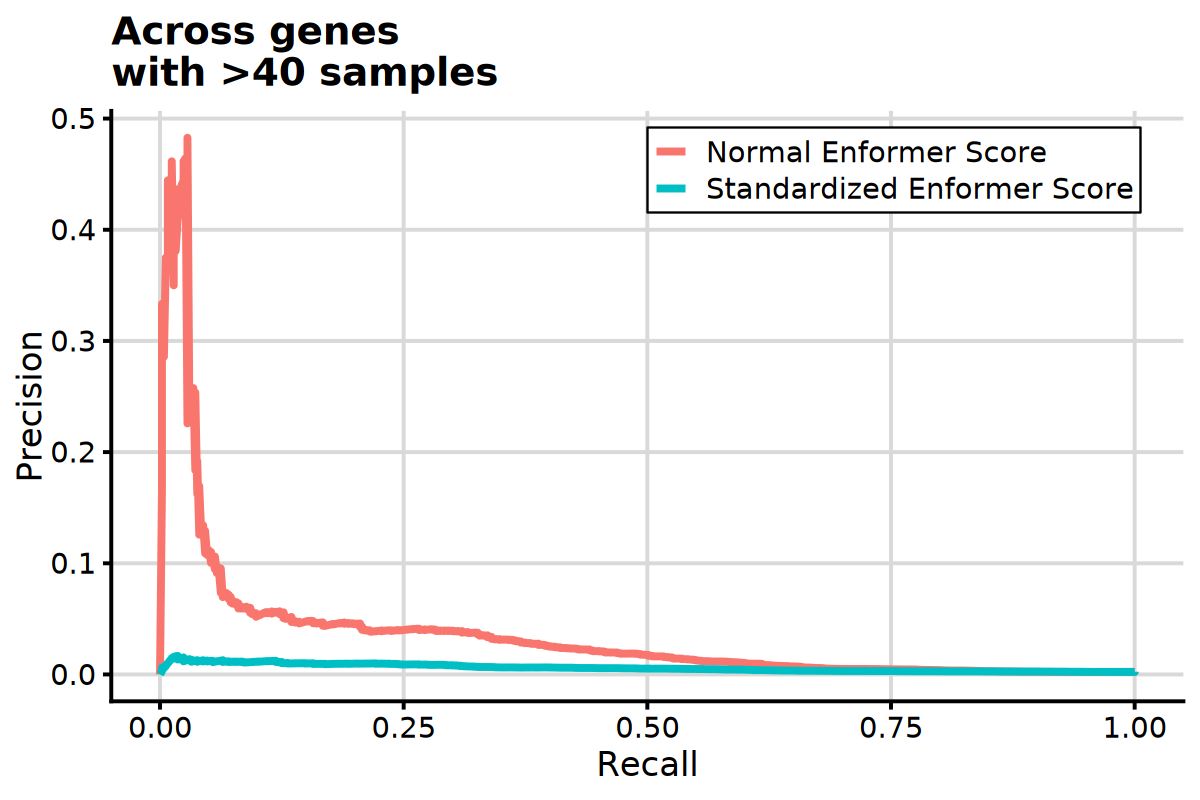

In [26]:
options(repr.plot.width=6, repr.plot.height=4, repr.plot.res=200)
p = ggplot(prc_data, aes(x = Recall, y = Precision, color = Method)) +
  geom_line(size = 1) +
  labs(title = "Across genes\nwith >40 samples",
       x = "Recall", 
       y = "Precision") +
  THEME + background_grid() +
  theme(legend.position = c(0.5, 0.9),
        legend.margin=margin(2,25,2,2),
        legend.background=element_rect(fill='white', color='black', linewidth=0.3))+
  # scale_color_manual(values = c("blue", "orange")) +
  theme(legend.title = element_blank())
p

In [27]:
width=6
height=4

path = paste(output_path, 'standardized_enformer_prc', sep='/')
print(paste0("Saving to ", path, "..."))
ggsave(paste0(path, ".png"), p, width = width, height = height, dpi=600, type='cairo')

[1] "Saving to /data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/plots/standardized_enformer_prc..."


Warning message:
“Using ragg device as default. Ignoring `type` and `antialias` arguments”


## Test for gene effects

In [28]:
# keep genes with at least 1 outlier
genes_with_outliers = df[is_underexpressed_outlier==TRUE, unique(gene)]
df = df[gene %in% genes_with_outliers]

In [29]:
gene_abundance <- df[, .(abundance = .N), by = `gene`]

In [30]:
top_genes <- gene_abundance[order(-abundance)][1:50]

In [31]:
tissue_abundance <- df[, .(abundance = .N), by = `tissue`]

In [32]:
top_tissues <- tissue_abundance[order(-abundance)][1:10]

In [33]:
subset_df = df[gene %in% top_genes$gene]

In [34]:
null_model <- lm(`zscore` ~ `enformer@Enformer`, data = subset_df)

In [35]:
null_model


Call:
lm(formula = zscore ~ `enformer@Enformer`, data = subset_df)

Coefficients:
        (Intercept)  `enformer@Enformer`  
            -0.6873               8.4802  


In [36]:
alt_model <- lm(`zscore` ~ `enformer@Enformer` * `gene`, data = subset_df)

In [37]:
summary(alt_model)


Call:
lm(formula = zscore ~ `enformer@Enformer` * gene, data = subset_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.0856 -0.8469  0.1491  1.0870  6.8860 

Coefficients:
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                              -1.17926    0.20110  -5.864 4.81e-09
`enformer@Enformer`                     -14.94639    9.17705  -1.629 0.103448
geneENSG00000063322                       0.28633    0.28548   1.003 0.315921
geneENSG00000070610                       1.20970    0.28933   4.181 2.95e-05
geneENSG00000071082                      -0.03682    0.31247  -0.118 0.906196
geneENSG00000083444                       0.39294    0.31268   1.257 0.208935
geneENSG00000093010                       0.72718    0.25154   2.891 0.003858
geneENSG00000100348                      -0.07691    0.27467  -0.280 0.779483
geneENSG00000105379                       0.67651    0.29306   2.308 0.021017
geneENSG00000106628                 

In [38]:
lrt_result <- anova(null_model, alt_model)

In [39]:
lrt_result

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4939,19347.92,NA,NA,NA,NA
2,4841,14250.28,98,5097.641,17.67074,1.969597e-248


In [40]:
coef_table <- summary(alt_model)$coefficients %>% as.data.table(keep.rownames = TRUE)
coef_table[, gene := sub('`enformer@Enformer`:', '', rn) %>% sub("gene", "", .)]

In [41]:
coef_table[order(`t value`, decreasing = TRUE)]

rn,Estimate,Std. Error,t value,Pr(>|t|),gene
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
`enformer@Enformer`:geneENSG00000166441,226.2885473,15.8640618,14.264225,2.987022e-45,ENSG00000166441
geneENSG00000166441,2.8739915,0.3592688,7.999558,1.549963e-15,ENSG00000166441
geneENSG00000156411,2.1058498,0.3040257,6.926552,4.876492e-12,ENSG00000156411
`enformer@Enformer`:geneENSG00000135108,68.8104243,10.9605866,6.277987,3.729643e-10,ENSG00000135108
`enformer@Enformer`:geneENSG00000138326,63.7145264,10.1630780,6.269216,3.944109e-10,ENSG00000138326
geneENSG00000124172,2.1611666,0.3624141,5.963251,2.648261e-09,ENSG00000124172
geneENSG00000158604,1.9822482,0.3698945,5.358955,8.758732e-08,ENSG00000158604
geneENSG00000143653,1.5626676,0.3045363,5.131301,2.989942e-07,ENSG00000143653
`enformer@Enformer`:geneENSG00000143149,55.5458152,10.8654950,5.112129,3.308182e-07,ENSG00000143149


In [42]:
# best_genes = coef_table[order(`Pr(>|t|)`)][1:10, gene] %>% .[1:10]

In [43]:
best_genes = c('ENSG00000166441', 'ENSG00000135108', 'ENSG00000138326', 'ENSG00000143149', 'ENSG00000265681', 'ENSG00000111731', 'ENSG00000266173', 'ENSG00000158604')

In [44]:
best_genes_df = df[gene %in% best_genes]

In [60]:
ensembl <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")

In [61]:
gene_symbol_map = getBM(attributes = c('ensembl_gene_id', 'hgnc_symbol'),
                   filters = 'ensembl_gene_id',
                   values = best_genes_df$gene %>% unique,
                   mart = ensembl) %>% as.data.table
gene_symbol_map[, gene := ensembl_gene_id]

In [62]:
best_genes_df = best_genes_df[gene_symbol_map, on=.(gene)]

In [63]:
best_genes_df[, N := .N, by = gene]
best_genes_df[, R2 := round(summary(lm(zscore ~ `enformer@Enformer`))$r.squared, 3), by = gene]
best_genes_df[, Correlation := cor(`enformer@Enformer`, zscore), by = gene]
best_genes_df[, individuals := length(unique(individual)), by = gene]
best_genes_df[, label := paste0(hgnc_symbol,': ', N,' samples')]

In [65]:
head(best_genes_df)

gene,tissue,zscore,FDR,enformer@Enformer,individual,is_underexpressed_outlier,N,R2,Correlation,individuals,label,standardized_enformer,ensembl_gene_id,hgnc_symbol,i.ensembl_gene_id,i.hgnc_symbol
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<int>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
ENSG00000111731,Adipose - Visceral (Omentum),-3.485036,1.000000e+00,-0.01895031,GTEX-132NY,FALSE,107,0.429,0.6549836,6,C2CD5: 107 samples,-0.3110666,ENSG00000111731,C2CD5,ENSG00000111731,C2CD5
ENSG00000111731,Adrenal Gland,-4.173706,3.930055e-01,0.01457886,GTEX-132NY,FALSE,107,0.429,0.6549836,6,C2CD5: 107 samples,0.3582875,ENSG00000111731,C2CD5,ENSG00000111731,C2CD5
ENSG00000111731,Artery - Tibial,-6.228821,4.075766e-05,-0.09243541,GTEX-132NY,TRUE,107,0.429,0.6549836,6,C2CD5: 107 samples,-1.7780744,ENSG00000111731,C2CD5,ENSG00000111731,C2CD5
ENSG00000111731,Breast - Mammary Tissue,-4.516473,3.986889e-01,-0.08268602,GTEX-132NY,FALSE,107,0.429,0.6549836,6,C2CD5: 107 samples,-1.5834441,ENSG00000111731,C2CD5,ENSG00000111731,C2CD5
ENSG00000111731,Colon - Sigmoid,-2.914699,1.000000e+00,-0.05816938,GTEX-132NY,FALSE,107,0.429,0.6549836,6,C2CD5: 107 samples,-1.0940100,ENSG00000111731,C2CD5,ENSG00000111731,C2CD5
ENSG00000111731,Esophagus - Gastroesophageal Junction,-2.644068,1.000000e+00,-0.07440037,GTEX-132NY,FALSE,107,0.429,0.6549836,6,C2CD5: 107 samples,-1.4180349,ENSG00000111731,C2CD5,ENSG00000111731,C2CD5


`geom_smooth()` using formula = 'y ~ x'


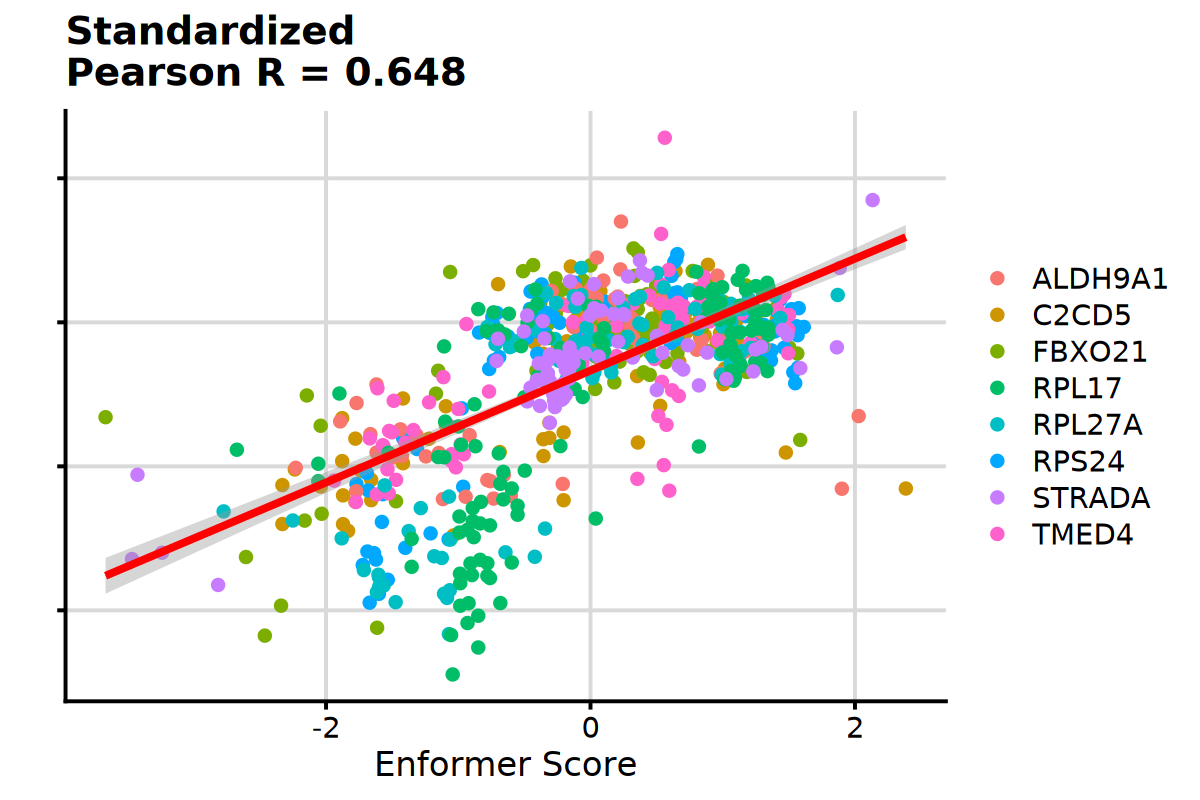

In [66]:
options(repr.plot.width=6, repr.plot.height=4, repr.plot.res=200)
correlation = round(best_genes_df[,cor(zscore,standardized_enformer)], 3)

# Create scatter plots for the top 3 genes
p2 = ggplot(best_genes_df, aes(x = `standardized_enformer`, y = `zscore`, color=hgnc_symbol)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE, color='red') +  # Add regression lines
  labs(x = "Enformer Score",
       y = "", title=paste0('Standardized\nPearson R = ', correlation)) +
  THEME + background_grid() + theme(axis.text.y=element_blank(), legend.margin = margin(0, 10, 0, 0), legend.title = element_blank())
p2

`geom_smooth()` using formula = 'y ~ x'


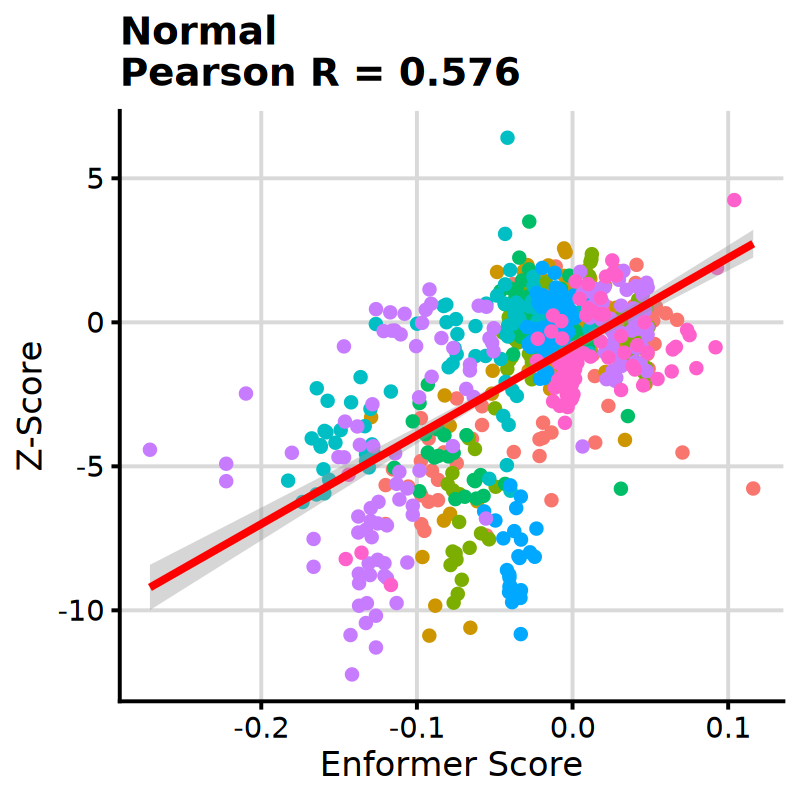

In [67]:
options(repr.plot.width=4, repr.plot.height=4, repr.plot.res=200)
correlation = round(best_genes_df[,cor(zscore,`enformer@Enformer`)], 3)

# Create scatter plots for the top 3 genes
p1 = ggplot(best_genes_df, aes(x = `enformer@Enformer`, y = `zscore`, color=gene)) +
  geom_point(show.legend = FALSE) +
  geom_smooth(method = "lm", se = TRUE, color='red') +  # Add regression lines
  labs(x = "Enformer Score",
       y = "Z-Score", title=paste0('Normal\nPearson R = ', correlation)) +
  THEME + background_grid()
p1

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


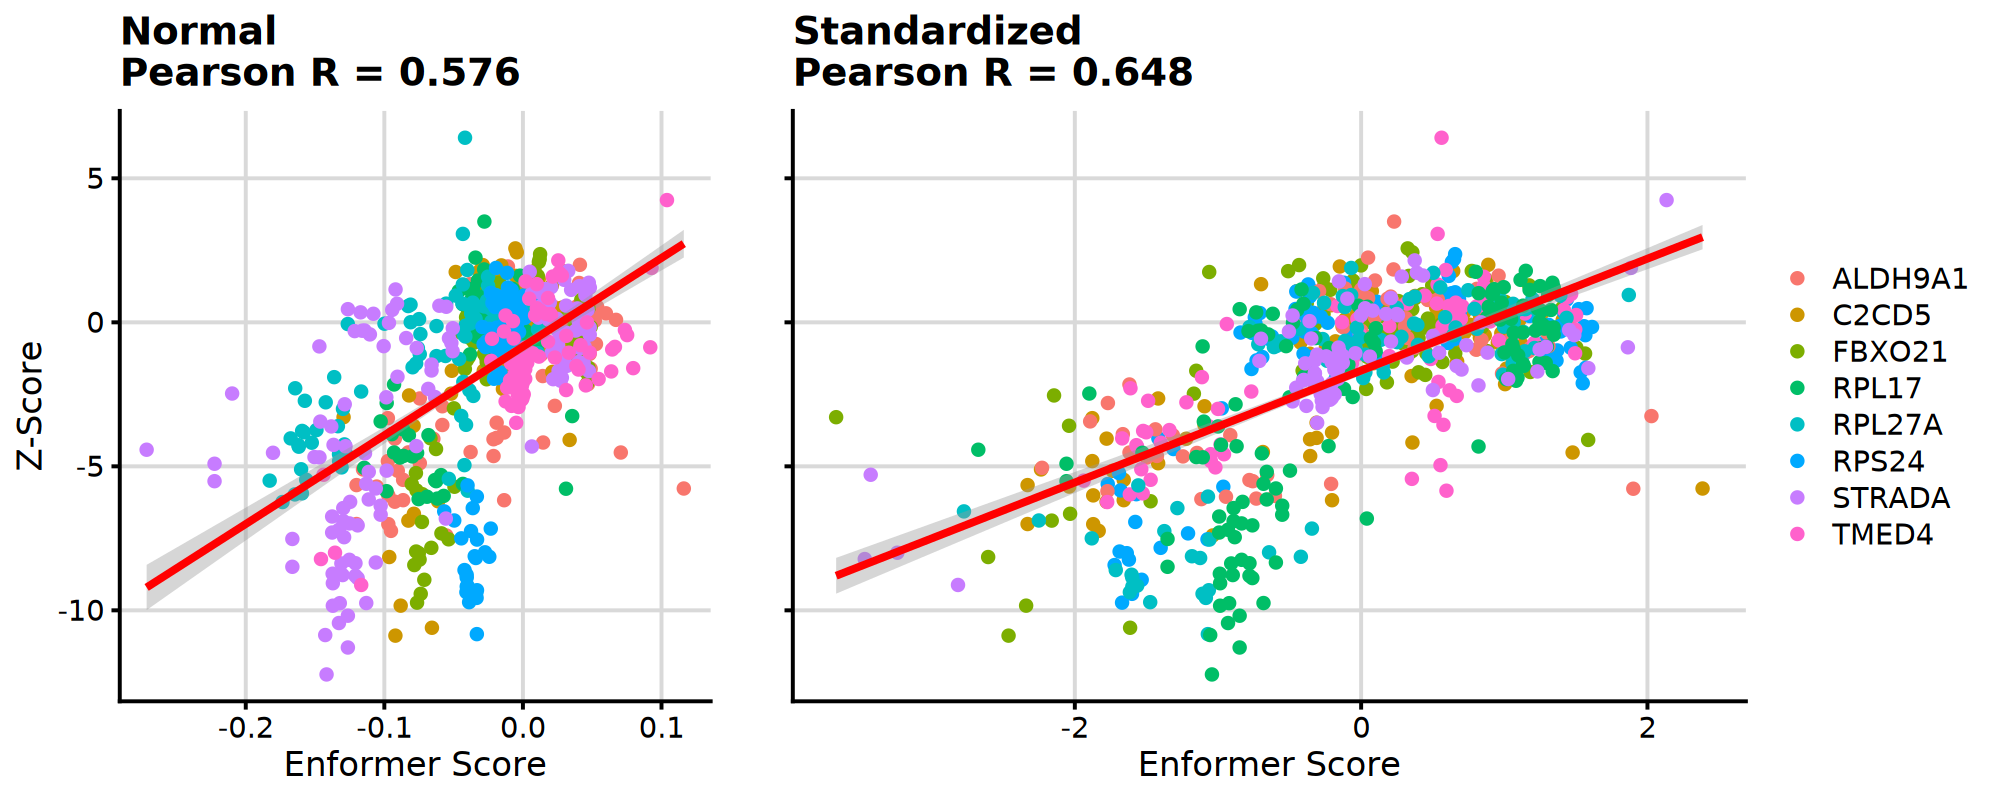

In [68]:
options(repr.plot.width=10, repr.plot.height=4, repr.plot.res=200)
p3 <- plot_grid(p1, p2, rel_widths = c(4, 7))
p3

In [69]:
width=10
height=4

path = paste(output_path, 'standardized_enformer_scatter', sep='/')
print(paste0("Saving to ", path, "..."))
ggsave(paste0(path, ".png"), p3, width = width, height = height, dpi=600, type='cairo')

[1] "Saving to /data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/plots/standardized_enformer_scatter..."


Warning message:
“Using ragg device as default. Ignoring `type` and `antialias` arguments”


`geom_smooth()` using formula = 'y ~ x'


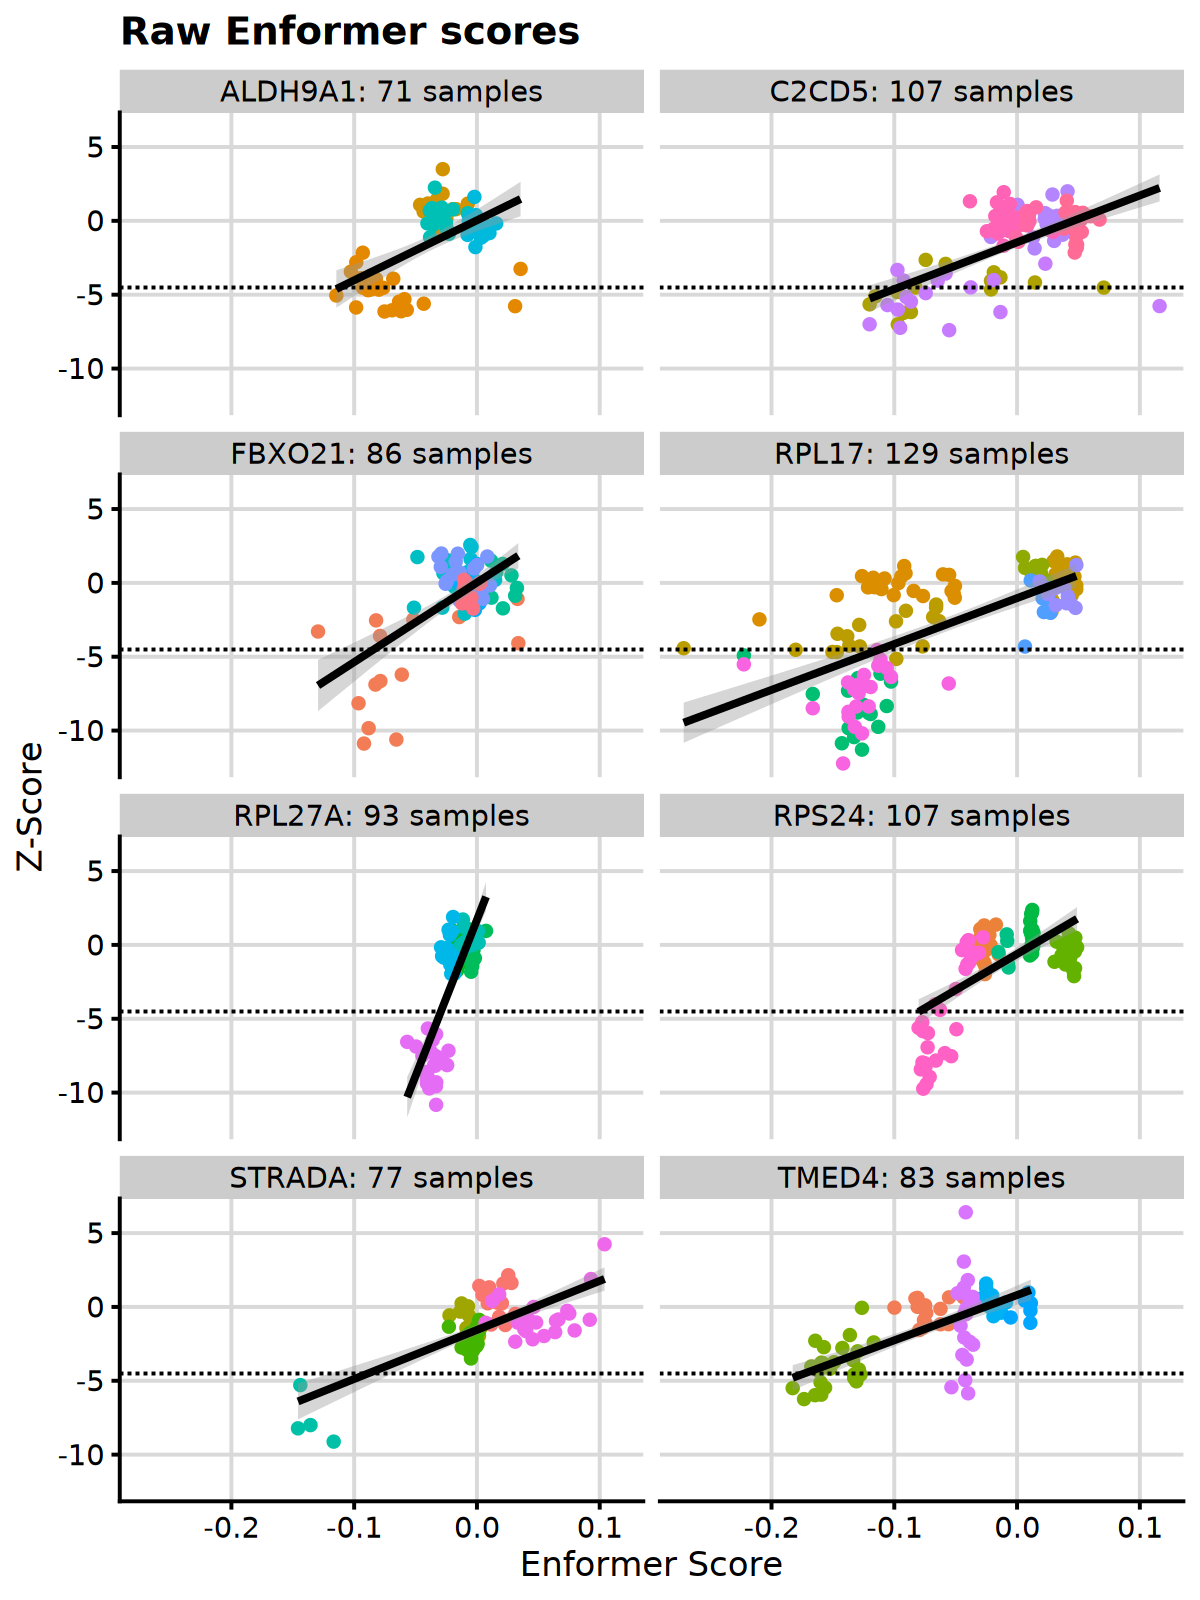

In [70]:
options(repr.plot.width=6, repr.plot.height=8, repr.plot.res=200)
# Create scatter plots for the top 3 genes
p1 = ggplot(best_genes_df, aes(x = `enformer@Enformer`, y = `zscore`, color = `individual`)) +
  geom_point(show.legend=FALSE) +
  geom_smooth(method = "lm", se = TRUE, color='black') +  # Add regression lines
  labs(title = "Raw Enformer scores",
       x = "Enformer Score",
       y = "Z-Score") +
  facet_wrap(~label, ncol=2) + 
  THEME + background_grid() +
  geom_hline(yintercept = -4.51258373260498, linetype = "dashed", color = "black") # Add dashed horizontal line
p1

`geom_smooth()` using formula = 'y ~ x'


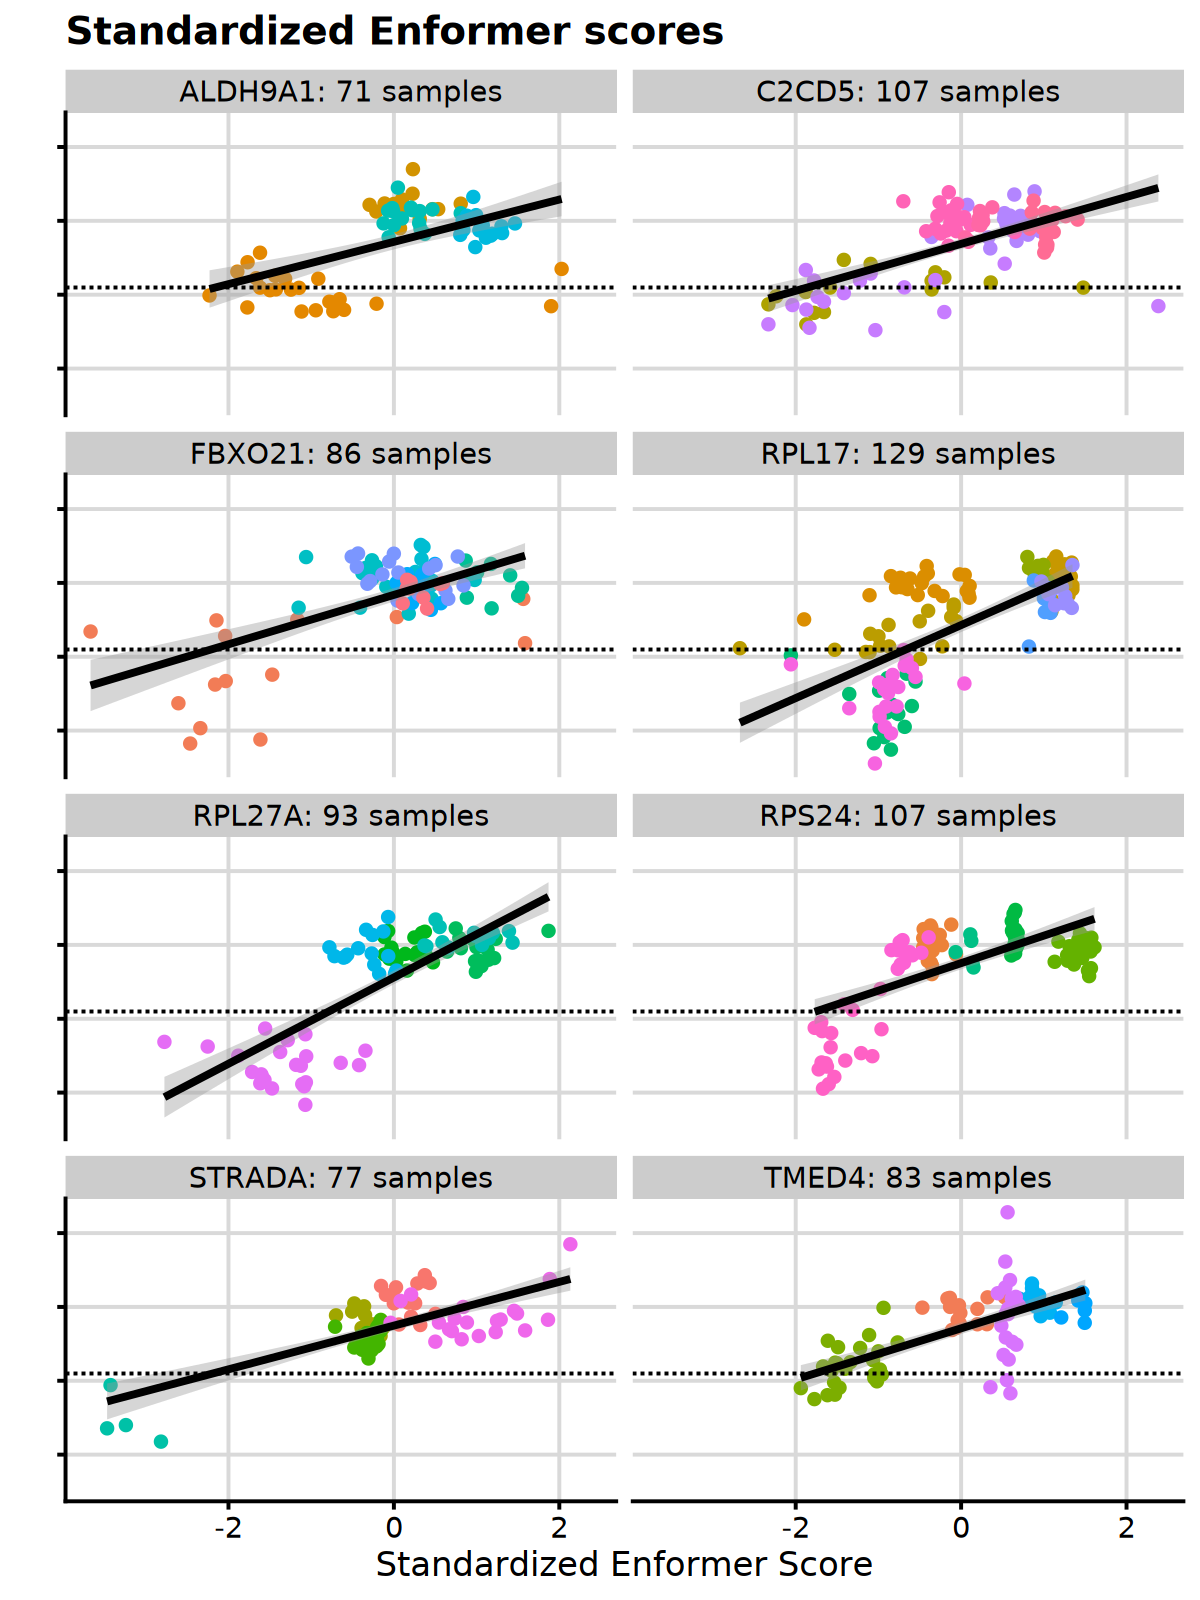

In [71]:
options(repr.plot.width=6, repr.plot.height=8, repr.plot.res=200)
# Create scatter plots for the top 3 genes
p2 = ggplot(best_genes_df, aes(x = `standardized_enformer`, y = `zscore`, color = `individual`)) +
  geom_point(show.legend=FALSE) +
  geom_smooth(method = "lm", se = TRUE, color='black') +  # Add regression lines
  labs(title = "Standardized Enformer scores",
       x = "Standardized Enformer Score",
       y = "") +
  facet_wrap(~label, ncol=2) + 
  THEME + background_grid()+ theme(axis.text.y=element_blank()) +
  geom_hline(yintercept = -4.51258373260498, linetype = "dashed", color = "black") # Add dashed horizontal line
p2

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


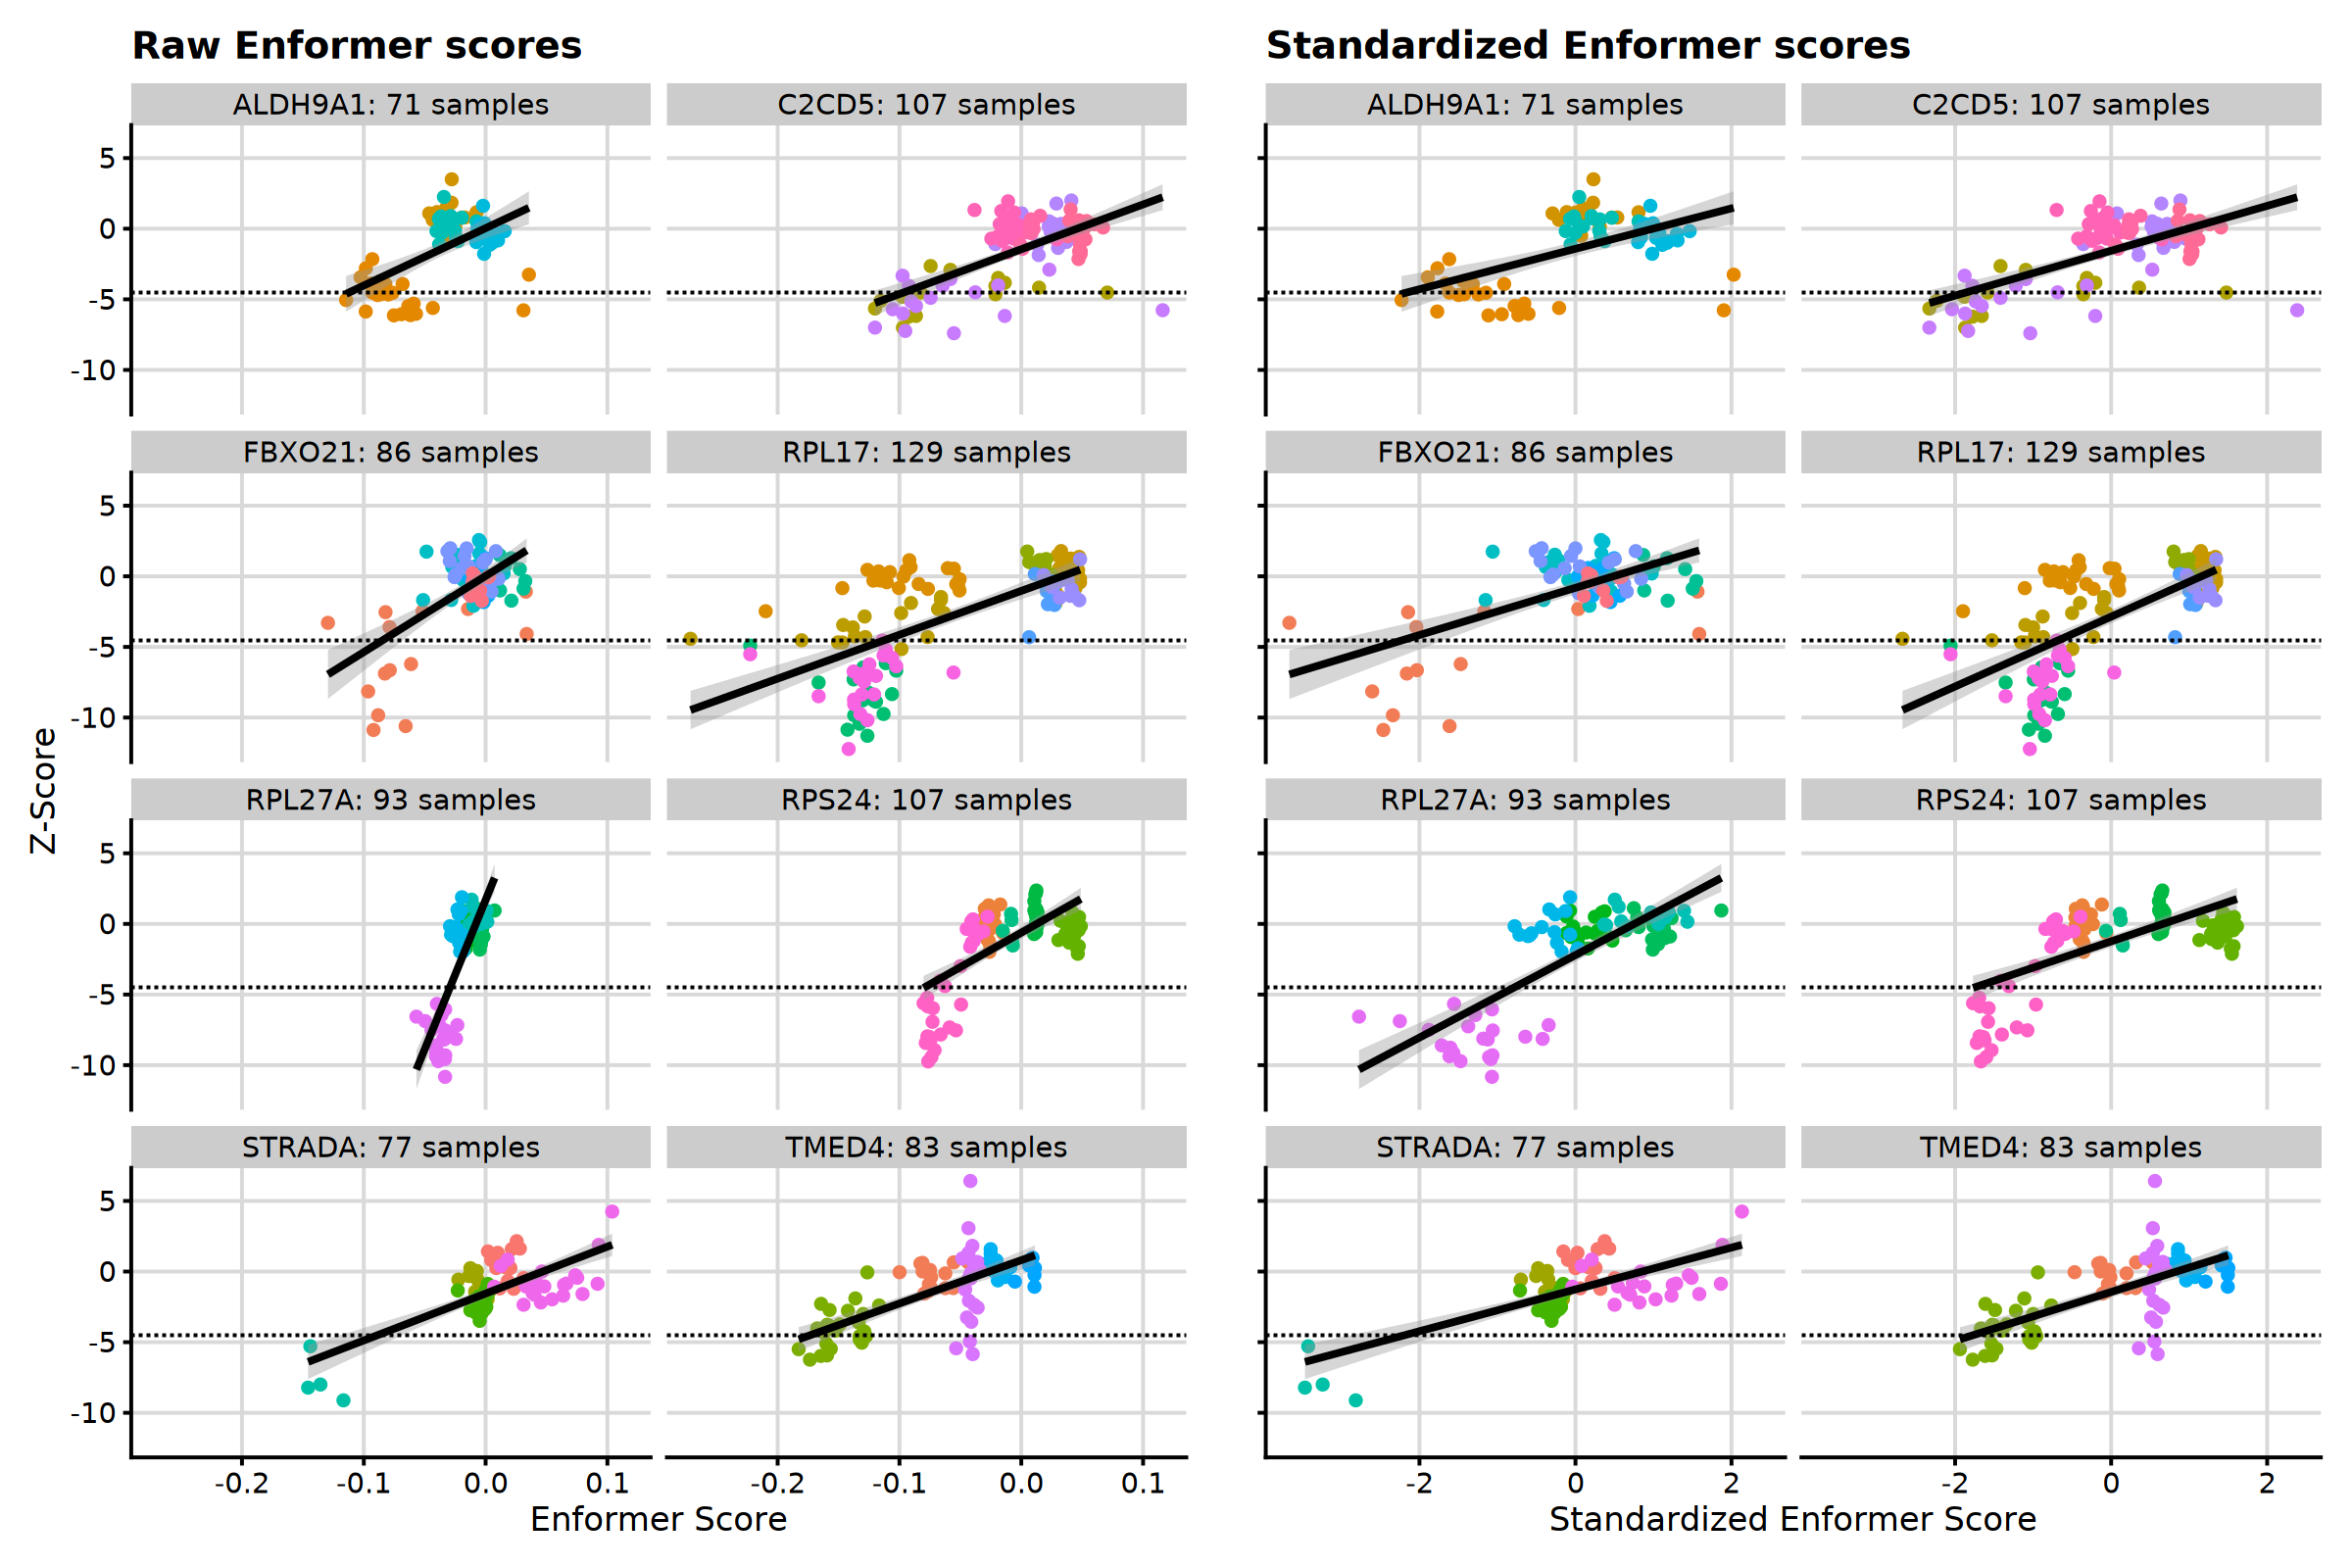

In [72]:
options(repr.plot.width=12, repr.plot.height=8, repr.plot.res=200)
p3 = p1 | p2
p3

In [73]:
width=12
height=8

path = paste(output_path, 'enformer_standardized_genes', sep='/')
print(paste0("Saving to ", path, "..."))
ggsave(paste0(path, ".png"), p3, width = width, height = height, dpi=600, type='cairo')

[1] "Saving to /data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/plots/enformer_standardized_genes..."


Warning message:
“Using ragg device as default. Ignoring `type` and `antialias` arguments”
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


### Permutation test

In [278]:
random_df <- copy(subset_df)
run_lrt <- function() {
    # Shuffle the gene column
    random_df[, gene := sample(gene)]

    # Fit the null model (no interaction)
    null_model <- lm(zscore ~ `enformer@Enformer`, data = random_df)
  
    # Fit the alternative model (with interaction)
    alt_model <- lm(zscore ~ `enformer@Enformer` * gene, data = random_df)
  
    # Perform the likelihood ratio test
    lrt_result <- anova(null_model, alt_model)
  
    # Return the p-value for the comparison of models (interaction term p-value)
    return(lrt_result$`Pr(>F)`[2])
}

In [285]:
p_values <- replicate(10000, run_lrt())

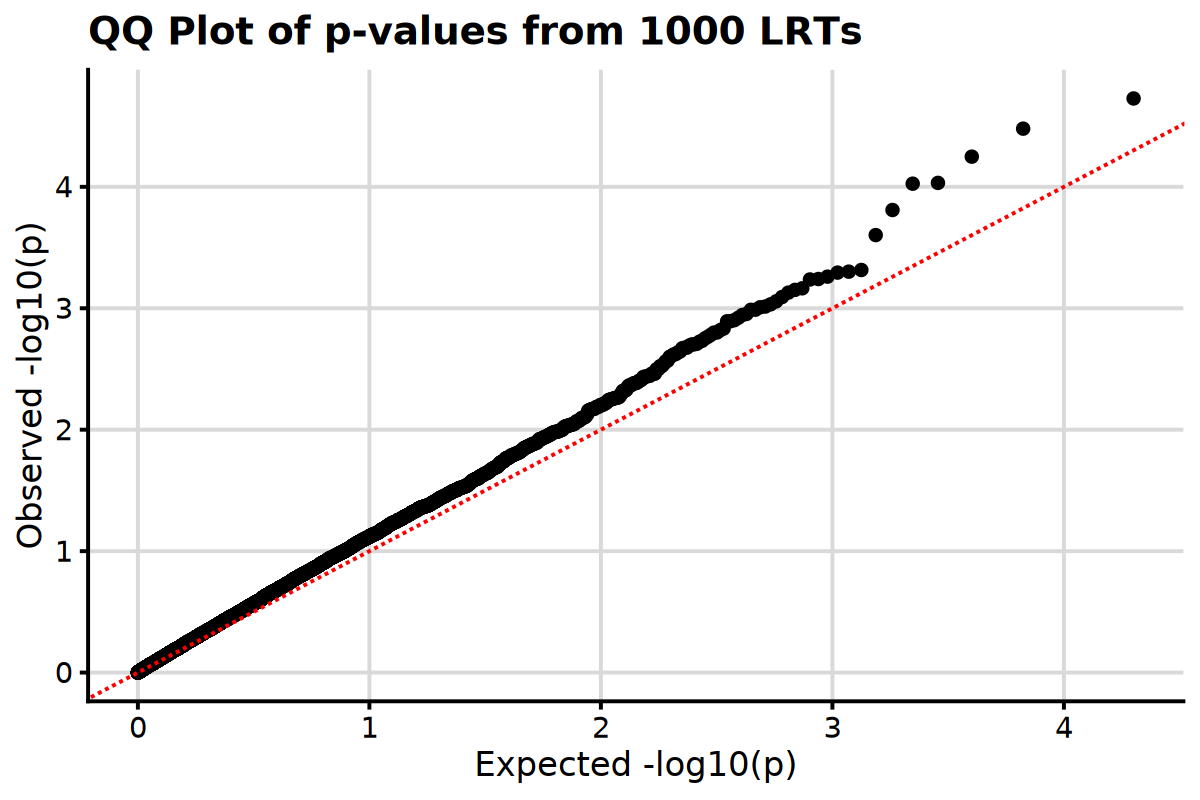

In [286]:
options(repr.plot.width=6, repr.plot.height=4, repr.plot.res=200)
# Create a QQ plot
observed_pvals <- sort(p_values)
expected_pvals <- -log10(ppoints(10000))  # Expected p-values under uniform distribution

# QQ plot using ggplot2
p = ggplot(data = data.frame(observed = -log10(observed_pvals), expected = expected_pvals), aes(x = expected, y = observed)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  labs(title = "QQ Plot of p-values from 1000 LRTs",
       x = "Expected -log10(p)",
       y = "Observed -log10(p)") +
  THEME + background_grid()
p

In [287]:
width=6
height=4

path = paste(output_path, 'enformer_genes_qqplot', sep='/')
print(paste0("Saving to ", path, "..."))
ggsave(paste0(path, ".png"), p, width = width, height = height, dpi=600, type='cairo')

[1] "Saving to /data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/plots/enformer_genes_qqplot..."


Warning message:
“Using ragg device as default. Ignoring `type` and `antialias` arguments”
